
# RealWaste — Inception V3 (Using Manifest + Numpy Splits)

This notebook loads the dataset **from your manifest-driven splits** saved as `.npy` files:
- `filepaths.npy`, `labels_encoded.npy`, `class_names.npy`
- `split_train.npy`, `split_val.npy`, `split_test.npy`
- `mean_std.npy` (optional: dataset mean/std you computed)

It fine-tunes **Inception V3** and reports **Accuracy, macro Precision/Recall/F1** and a **confusion matrix**.

> **Prereq:** Run your `02_Splits_MeanStd_AugPreview.ipynb` first to generate the npy files.


In [2]:

# (Optional) Install dependencies if needed
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install scikit-learn matplotlib pandas tqdm pillow numpy


In [3]:

from pathlib import Path
import numpy as np

# === Paths to your NPZ/NPY assets ===
SPLITS_DIR = Path("C:/Users/User/Desktop/CNN asignment/code/pre_trained_models")  # change if your npy files are elsewhere

FILEPATHS_NPY = SPLITS_DIR / "filepaths.npy"
LABELS_NPY    = SPLITS_DIR / "labels_encoded.npy"
CLASSES_NPY   = SPLITS_DIR / "class_names.npy"
TRAIN_NPY     = SPLITS_DIR / "split_train.npy"
VAL_NPY       = SPLITS_DIR / "split_val.npy"
TEST_NPY      = SPLITS_DIR / "split_test.npy"
MEAN_STD_NPY  = SPLITS_DIR / "mean_std.npy"   # optional

# === Training config ===
OUTPUT_DIR = Path("./outputs/inception_v3_realwaste_splits").resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 133
BATCH_SIZE = 32
HEAD_EPOCHS = 5
FT_EPOCHS = 25
BASE_LR = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.1
IMG_SIZE = 299  # Inception V3


In [4]:

import random, os, numpy as np, torch

def set_seed(seed=133):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [5]:
import numpy as np
# Load arrays
filepaths = np.load(FILEPATHS_NPY, allow_pickle=True)
labels    = np.load(LABELS_NPY)
classes   = np.load(CLASSES_NPY, allow_pickle=True).tolist()
idx_tr    = np.load(TRAIN_NPY)
idx_va    = np.load(VAL_NPY)
idx_te    = np.load(TEST_NPY)

# Mean/std if you computed them; else fall back to ImageNet stats
try:
    mean_std = np.load(MEAN_STD_NPY)
    mean = mean_std[0].tolist()
    std  = mean_std[1].tolist()
    print("Using dataset mean/std:", mean, std)
except Exception as e:
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    print("No mean_std.npy found; using ImageNet stats.")
    
len(classes), classes[:5], len(idx_tr), len(idx_va), len(idx_te)


Using dataset mean/std: [0.598393759260575, 0.6187966115872066, 0.6307503436009089] [0.1635656363186559, 0.1645716954870396, 0.18778279659653346]


(9,
 ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash'],
 3326,
 713,
 713)

In [6]:

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class NpySplitDataset(Dataset):
    def __init__(self, filepaths, labels, indices, img_size=299, train=True, mean=None, std=None):
        self.filepaths = filepaths
        self.labels = labels
        self.indices = indices
        self.train = train
        self.mean = mean or [0.485,0.456,0.406]
        self.std  = std  or [0.229,0.224,0.225]
        if train:
            self.tf = transforms.Compose([
                transforms.Resize(int(img_size*1.15)),
                transforms.CenterCrop(img_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(0.1,0.1,0.1,0.05),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std),
            ])
        else:
            self.tf = transforms.Compose([
                transforms.Resize(int(img_size*1.15)),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std),
            ])
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        idx = int(self.indices[i])
        fp = str(self.filepaths[idx])
        y  = int(self.labels[idx])
        img = Image.open(fp).convert("RGB")
        x = self.tf(img)
        return x, y

train_ds = NpySplitDataset(filepaths, labels, idx_tr, img_size=IMG_SIZE, train=True,  mean=mean, std=std)
val_ds   = NpySplitDataset(filepaths, labels, idx_va, img_size=IMG_SIZE, train=False, mean=mean, std=std)
test_ds  = NpySplitDataset(filepaths, labels, idx_te, img_size=IMG_SIZE, train=False, mean=mean, std=std)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(3326, 713, 713)

In [7]:

import torch.nn as nn
from torchvision import models

def make_inception_v3(num_classes: int, aux_logits=True):
    m = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=aux_logits)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    if aux_logits and hasattr(m, "AuxLogits") and m.AuxLogits:
        m.AuxLogits.fc = nn.Linear(m.AuxLogits.fc.in_features, num_classes)
    return m

model = make_inception_v3(num_classes=len(classes), aux_logits=True).to(device)
model


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [8]:

import torch, torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

def train_one_epoch(model, dl, optimizer, device, use_aux=True, smoothing=0.1):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in tqdm(dl, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        if use_aux and isinstance(out, tuple):  # (main, aux)
            out_main, out_aux = out
            loss = F.cross_entropy(out_main, y, label_smoothing=smoothing) +                    0.4 * F.cross_entropy(out_aux, y, label_smoothing=smoothing)
            pred = out_main.argmax(1)
        else:
            loss = F.cross_entropy(out, y, label_smoothing=smoothing)
            pred = out.argmax(1)
        loss.backward()
        optimizer.step()

        bs = y.size(0)
        loss_sum += loss.item() * bs
        correct  += (pred == y).sum().item()
        total    += bs

    return loss_sum/total, correct/total

@torch.no_grad()
def evaluate(model, dl, device, use_aux=True):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        if use_aux and isinstance(out, tuple):
            out = out[0]
        loss = F.cross_entropy(out, y)
        pred = out.argmax(1)

        bs = y.size(0)
        loss_sum += loss.item() * bs
        correct  += (pred == y).sum().item()
        total    += bs

    return loss_sum/total, correct/total


In [9]:

# 1) Train classifier head only
for p in model.parameters():
    p.requires_grad = False

if hasattr(model, "fc"):
    for p in model.fc.parameters():
        p.requires_grad = True
if hasattr(model, "AuxLogits") and model.AuxLogits:
    for p in model.AuxLogits.parameters():
        p.requires_grad = True

opt = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
sch = CosineAnnealingLR(opt, T_max=HEAD_EPOCHS)

use_aux = True
best_val_acc = -1.0
best_state = None

for ep in range(1, HEAD_EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_dl, opt, device, use_aux, LABEL_SMOOTH)
    va_loss, va_acc = evaluate(model, val_dl, device, use_aux)
    sch.step()
    print(f"[head][{ep:02d}/{HEAD_EPOCHS}] train_acc={tr_acc:.4f}  val_acc={va_acc:.4f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

# Save head-only best (optional)
from pathlib import Path
if best_state is not None:
    head_ckpt = Path(OUTPUT_DIR) / "inception_v3_head_best.pth"
    import torch
    torch.save(best_state, head_ckpt)
    print("Saved:", head_ckpt)


[head][01/5] train_acc=0.3322  val_acc=0.6143


[head][02/5] train_acc=0.5520  val_acc=0.6760


[head][03/5] train_acc=0.6200  val_acc=0.6858


[head][04/5] train_acc=0.6434  val_acc=0.7027


[head][05/5] train_acc=0.6609  val_acc=0.7041
Saved: C:\Users\User\Desktop\CNN asignment\code\pre_trained_models\outputs\inception_v3_realwaste_splits\inception_v3_head_best.pth


In [10]:

# 2) Fine-tune all layers
for p in model.parameters():
    p.requires_grad = True

opt = AdamW(model.parameters(), lr=BASE_LR/3, weight_decay=WEIGHT_DECAY)
sch = CosineAnnealingLR(opt, T_max=FT_EPOCHS)

best_val_acc = -1.0
best_state = None

for ep in range(1, FT_EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_dl, opt, device, use_aux, LABEL_SMOOTH)
    va_loss, va_acc = evaluate(model, val_dl, device, use_aux)
    sch.step()
    print(f"[ft  ][{ep:02d}/{FT_EPOCHS}] train_acc={tr_acc:.4f}  val_acc={va_acc:.4f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

best_ckpt = Path(OUTPUT_DIR) / "inception_v3_best.pth"
if best_state is not None:
    import torch
    torch.save(best_state, best_ckpt)
    print("Saved best fine-tuned checkpoint:", best_ckpt)


[ft  ][01/25] train_acc=0.7865  val_acc=0.8583


[ft  ][02/25] train_acc=0.9429  val_acc=0.8962


[ft  ][03/25] train_acc=0.9826  val_acc=0.9060


[ft  ][04/25] train_acc=0.9913  val_acc=0.9088


[ft  ][05/25] train_acc=0.9952  val_acc=0.9144


[ft  ][06/25] train_acc=0.9979  val_acc=0.9144


[ft  ][07/25] train_acc=0.9982  val_acc=0.8962


[ft  ][08/25] train_acc=0.9976  val_acc=0.8990


[ft  ][09/25] train_acc=0.9991  val_acc=0.9130


[ft  ][10/25] train_acc=0.9991  val_acc=0.9032


[ft  ][11/25] train_acc=0.9991  val_acc=0.9144


[ft  ][12/25] train_acc=0.9991  val_acc=0.9116


[ft  ][13/25] train_acc=0.9994  val_acc=0.9130


[ft  ][14/25] train_acc=1.0000  val_acc=0.9158


[ft  ][15/25] train_acc=0.9994  val_acc=0.9102


[ft  ][16/25] train_acc=1.0000  val_acc=0.9116


[ft  ][17/25] train_acc=1.0000  val_acc=0.9074


[ft  ][18/25] train_acc=1.0000  val_acc=0.9116


[ft  ][19/25] train_acc=1.0000  val_acc=0.9102


[ft  ][20/25] train_acc=1.0000  val_acc=0.9116


[ft  ][21/25] train_acc=1.0000  val_acc=0.9144


[ft  ][22/25] train_acc=1.0000  val_acc=0.9102


[ft  ][23/25] train_acc=1.0000  val_acc=0.9074


[ft  ][24/25] train_acc=1.0000  val_acc=0.9158


[ft  ][25/25] train_acc=0.9997  val_acc=0.9187
Saved best fine-tuned checkpoint: C:\Users\User\Desktop\CNN asignment\code\pre_trained_models\outputs\inception_v3_realwaste_splits\inception_v3_best.pth


In [11]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import torch

@torch.no_grad()
def predict_all(model, dl, device, use_aux=True):
    model.eval()
    ys, ps = [], []
    for x, y in dl:
        x = x.to(device)
        out = model(x)
        if use_aux and isinstance(out, tuple):
            out = out[0]
        pred = out.argmax(1).cpu().numpy()
        ys.append(y.numpy())
        ps.append(pred)
    y = np.concatenate(ys)
    p = np.concatenate(ps)
    return y, p

# Load best weights
state = torch.load(best_ckpt, map_location="cpu")
model.load_state_dict(state)

test_loss, test_acc = evaluate(model, test_dl, device, use_aux=True)
y_true, y_pred = predict_all(model, test_dl, device, use_aux=True)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

print("Test Accuracy:", acc)
print("Macro Precision:", prec)
print("Macro Recall:", rec)
print("Macro F1:", f1)

# Save metrics to CSV
df = pd.DataFrame([{
    "model": "inception_v3",
    "accuracy": acc,
    "precision_macro": prec,
    "recall_macro": rec,
    "f1_macro": f1
}])
csv_path = Path(OUTPUT_DIR) / "results.csv"
df.to_csv(csv_path, index=False)
csv_path


Test Accuracy: 0.9172510518934082
Macro Precision: 0.9247611093601201
Macro Recall: 0.9205746016436829
Macro F1: 0.9224007404867294


WindowsPath('C:/Users/User/Desktop/CNN asignment/code/pre_trained_models/outputs/inception_v3_realwaste_splits/results.csv')

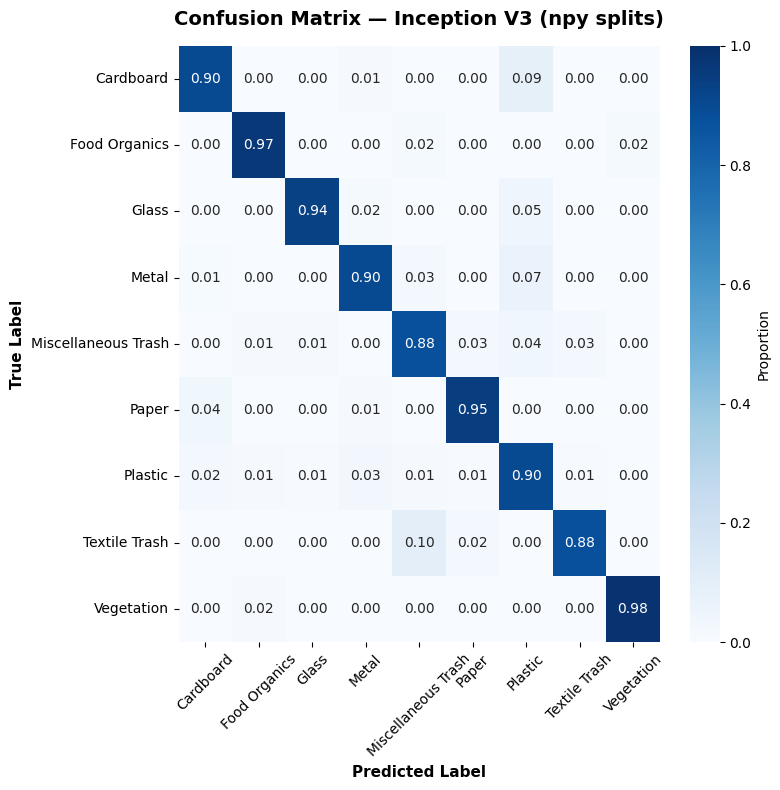

WindowsPath('C:/Users/User/Desktop/CNN asignment/code/pre_trained_models/outputs/inception_v3_realwaste_splits/confusion_matrix_inception_v3_splits.png')

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pathlib import Path

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
fig = plt.figure(figsize=(8, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=classes,
    yticklabels=classes,
    cbar_kws={'label': 'Proportion'},
    vmin=0,
    vmax=1
)

plt.title('Confusion Matrix — Inception V3 (npy splits)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure
cm_path = Path(OUTPUT_DIR) / "confusion_matrix_inception_v3_splits.png"
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()

cm_path
